In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gensim
from gensim.models import word2vec  
from sklearn.manifold import TSNE  
import re  
import nltk  
from nltk.corpus import stopwords  
from nltk.stem.porter import *  
stemmer = PorterStemmer()  
from nltk.stem import PorterStemmer
from pyspark.sql.session import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pyspark.sql.functions as sf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark import SparkContext, SparkConf, HiveContext
from pyspark.sql.functions import col, asc, desc
from pyspark.sql import SQLContext
from pyspark.ml.clustering import KMeans 
from pyspark.ml.evaluation import ClusteringEvaluator 
from pyspark.ml.feature import StandardScaler 
from scipy.spatial.distance import sqeuclidean
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_circles
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import euclidean_distances, adjusted_rand_score


In [78]:
class Model_Clasters:
    """
    Model_Clasters(filename:str,sub = "YourColoumn" ,claster_method:str)
    Class for creating w0rd2vec model of a text subset in your data and clasterisation. You can choose clasterisation method.
    Available clasterisation methods:
    
    "Kmeans"
    "AgglomerativeClustering"
    "DBSCAN"
    "AffinityPropagation"

    Class uses pyspark.
    For choosing number of clasters the silhouette method is used.
    You can see which word belongs to which claster by list under it. 0 is for red claster, 1 is for orange and etc.
    """
    def __init__(self,filename:str,sub:str,claster_method = "Kmeans"):
        self.data =  pd.DataFrame(pd.read_csv(filename,delimiter = ','))
        self.new_values = []
        self.accordance = {}
        self.data = self.data.dropna(subset=sub)
        proc = [self.rewiew_to(text) for text in self.data[sub]]
        res = self.str_to_lst(proc)
        self.model = word2vec.Word2Vec(res, window=5, min_count=100, workers=4)
        
        labeles = []
        tokens = []
        for word in self.model.wv.key_to_index:
            tokens.append(self.model.wv[word])
            labeles.append(word)
        tokens = np.array(tokens)
        tsne_model = TSNE(perplexity=40, n_components=2,init='pca', max_iter=2500)
        self.new_values = tsne_model.fit_transform(tokens)
        for l,t in zip(labeles,self.new_values):
            self.accordance[l] = t
            
        self.ac = pd.DataFrame.from_dict(self.accordance,orient="index")
        
        conf = SparkConf().setAppName('spark_dlab_app') 
        spark = SparkSession.builder.getOrCreate()
        
        nv = pd.DataFrame(self.new_values)
        nv.to_csv("Vectors.csv",header = False,index = False)
        nd  = spark.read.csv("Vectors.csv", sep=",",inferSchema=True)
        
        sc = SparkContext.getOrCreate()
        sqlContext = SQLContext(sc)
        vec_assembler = VectorAssembler(inputCols = nd.columns, 
                                        outputCol='features') 
        self.final_data = vec_assembler.transform(nd) 
        self.final_data.select('features')
        scaler = StandardScaler(inputCol="features",  
                        outputCol="scaledFeatures",  
                        withStd=True,  
                        withMean=False) 
  
        scalerModel = scaler.fit(self.final_data) 
        self.final_data = scalerModel.transform(self.final_data) 
        pf_final = self.final_data.toPandas()
        self.final_data.select('scaledFeatures')
        s = self.silhouette()
        match claster_method:
            case "Kmeans":
                self.Kmeans(s)
            case "AgglomerativeClustering":
                self.AgglomerativeClustering(s)
            case "DBSCAN":
                self.DBSCAN()
            case "AffinityPropagation":
                self.AffinityPropagation()

    def rewiew_to(self,raw):
        letters_only = re.sub("[^a-zA-Z]", " ",raw)
        words = letters_only.lower().split()
        stops = set(stopwords.words("english"))
        m_words = [w for w in words if not w in stops]
        lemma = nltk.wordnet.WordNetLemmatizer()
        singles = [lemma.lemmatize(word) for word in m_words]
        return (" ".join(singles))   
        
    def str_to_lst(self,text):
        res = []
        for elem in text:
            res.append([w for w in elem.split()])
        return res
        
    def show(self):
        x = []
        y = []
        for value in self.new_values:
            x.append(value[0])
            y.append(value[1])
        plt.figure(figsize=(8,8))
        for i in range(len(x)):
            plt.scatter(x[i],y[i])
            plt.annotate(labeles[i],xy = (x[i],y[i]),xytext = (5,2),
            textcoords= 'offset points',ha = 'right',va = 'bottom')
        plt.show()
       
    def silhouette(self,claster_method = ""):
        silhouette_score=[] 
        evaluator = ClusteringEvaluator(predictionCol='prediction', 
                                        featuresCol='scaledFeatures',  
                                        metricName='silhouette',  
                                        distanceMeasure='squaredEuclidean') 
        s = []
        for i in range(2,10): 
            kmeans=KMeans(featuresCol='scaledFeatures', k=i) 
            model=kmeans.fit(self.final_data) 
            predictions=model.transform(self.final_data) 
            score=evaluator.evaluate(predictions) 
            s.append([i,score])
            silhouette_score.append(score) 
            print('Silhouette Score for k =',i,'is',score)
        s = (min(s[4:],key = lambda s: s[1]))[0]
        plt.plot(range(2,10),silhouette_score) 
        plt.xlabel('k') 
        plt.ylabel('silhouette score') 
        plt.title('Silhouette Score') 
        plt.show()
        return s
    def Kmeans(self,claster_num):
        kmeans = KMeans(featuresCol='scaledFeatures',k=claster_num) 
        model = kmeans.fit(self.final_data)
        predictions = model.transform(self.final_data)
        x = self.final_data.select("_c0").toPandas()
        y = self.final_data.select("_c1").toPandas()
        x1 = list(x["_c0"])
        y1 = list(y["_c1"])
        pred = predictions.select("prediction").toPandas()
        pred = list(pred["prediction"])
        words = list(self.accordance.keys())
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
        for i,word in zip(range(130,len(x1)-150),words):
            ax.annotate(word,(x1[i],y1[i]),xytext = (x1[i]+0.3,y1[i]+0.3))
        plt.scatter(x1, y1, c = pred, cmap="rainbow")
        plt.show()
        self.ac["Predictions"] = pred
        clas = list(zip(words,pred))
        clas = sorted(clas,key = lambda clas:clas[1])
        centers = model.clusterCenters() 
        print("Cluster Centers: ") 
        for center in centers: 
            print(center)
        print(clas)
    def AgglomerativeClustering(self,num_clasters):
        AC = HierarchicalAgglomerativeClustering(n_clusters=num_clasters)
        x = self.final_data.select("_c0","_c1").toPandas()
        x = x.to_numpy()
        ac_pred_res = AC.fit_predict(x)
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
        plt.scatter(x[:, 0], x[:, 1], c=ac_pred_res, cmap='rainbow')
        plt.title('AgglomerativeClustering')
        words = list(self.accordance.keys())
        for i,word in zip(range(130,len(x[:,0])-150),words):
            ax.annotate(word,(x[:,0][i],x[:,1][i]),xytext = (x[:,0][i]+0.3,x[:,1][i]+0.3))
        clas = list(zip(words,ac_pred_res))
        clas = sorted(clas,key = lambda clas:clas[1])
        print(clas)
        plt.show()
    def DBSCAN(self):
        dbscan = DBSCANClustering(eps=0.5, min_samples=5)
        x = self.final_data.select("_c0","_c1").toPandas()
        x = x.to_numpy()
        dbscan_pred_res = dbscan.fit_predict(x)
        words = list(self.accordance.keys())
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111) 
        plt.title('DBSCAN')
        plt.scatter(x[:, 0], x[:, 1], c=dbscan_pred_res, cmap='rainbow')
        words = list(self.accordance.keys())
        for i,word in zip(range(130,len(x[:,0])-150),words):
            ax.annotate(word,(x[:,0][i],x[:,1][i]),xytext = (x[:,0][i]+0.3,x[:,1][i]+0.3))
        clas = list(zip(words,dbscan_pred_res))
        clas = sorted(clas,key = lambda clas:clas[1])
        print(clas)
        plt.show()
    def AffinityPropagation(self):
        ap = AffinityPropagationClustering()
        x = self.final_data.select("_c0","_c1").toPandas()
        x = x.to_numpy()
        ap_pred_res = ap.fit_predict(x)
        words = list(self.accordance.keys())
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
        plt.title('AffinityPropagation')
        plt.scatter(x[:, 0], x[:, 1], c=ap_pred_res, cmap='rainbow',s =10)
        plt.scatter(ap.cluster_centers_[:, 0], ap.cluster_centers_[:, 1], c='black', s=50)
        for i,word in zip(range(len(x[:,0])),words):
            ax.annotate(word,(x[:,0][i],x[:,1][i]),xytext = (x[:,0][i]+0.3,x[:,1][i]+0.3))
        clas = list(zip(words,ap_pred_res))
        clas = sorted(clas,key = lambda clas:clas[1])
        print(clas)
        plt.show()
    

C:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Silhouette Score for k = 2 is 0.7652266945276803
Silhouette Score for k = 3 is 0.6768969112110309
Silhouette Score for k = 4 is 0.603545213338366
Silhouette Score for k = 5 is 0.5521889504568234
Silhouette Score for k = 6 is 0.5456110875583724
Silhouette Score for k = 7 is 0.5151346698483091
Silhouette Score for k = 8 is 0.50213555783644
Silhouette Score for k = 9 is 0.5754074681738505


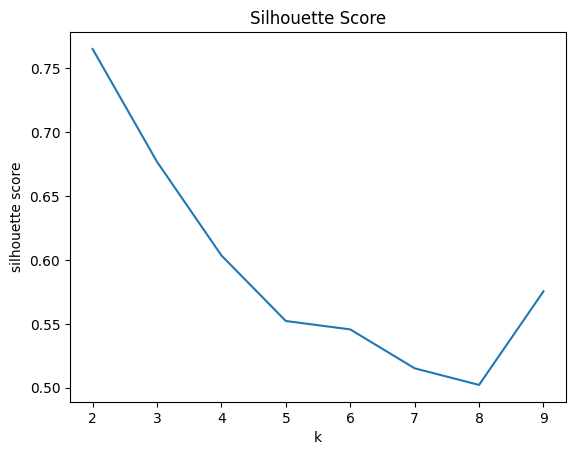

[('crew', 0), ('ground', 0), ('killed', 0), ('helicopter', 0), ('time', 0), ('attempt', 0), ('speed', 0), ('aboard', 0), ('collision', 0), ('take', 0), ('unknown', 0), ('undetermined', 0), ('crashed', 1), ('airport', 1), ('struck', 1), ('mile', 1), ('cargo', 1), ('foot', 1), ('short', 1), ('minute', 1), ('hit', 1), ('sea', 1), ('burned', 1), ('collided', 1), ('shot', 1), ('found', 1), ('near', 1), ('reported', 1), ('went', 1), ('wreckage', 1), ('pilot', 2), ('altitude', 2), ('route', 2), ('accident', 2), ('fog', 2), ('flying', 2), ('procedure', 2), ('descent', 2), ('improper', 2), ('maintain', 2), ('minimum', 2), ('lack', 2), ('inadequate', 2), ('snow', 2), ('flight', 3), ('approach', 3), ('mountain', 3), ('weather', 3), ('condition', 3), ('en', 3), ('poor', 3), ('low', 3), ('terrain', 3), ('vfr', 3), ('instrument', 3), ('visibility', 3), ('factor', 3), ('continued', 3), ('adverse', 3), ('contributing', 3), ('decision', 3), ('night', 3), ('visual', 3), ('ifr', 3), ('cloud', 3), ('clear

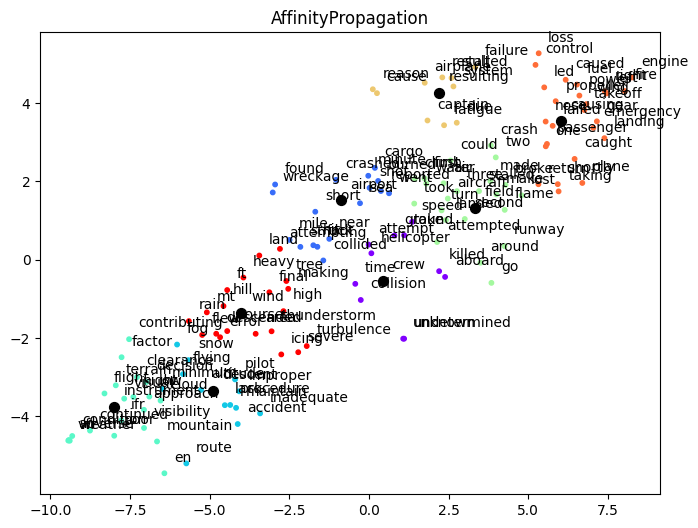

In [79]:
Model_Clasters("Airplane_Crashes_and_Fatalities_Since_1908.csv",sub= "Summary",claster_method="AffinityPropagation")

In [35]:
class HierarchicalAgglomerativeClustering:
    def __init__(self, n_clusters=2):
        self.n_clusters = n_clusters

    @staticmethod
    def _ward_distance(c1, c2):
        n1, n2 = len(c1), len(c2)
        c1_mean, c2_mean = np.mean(c1, axis=0), np.mean(c2, axis=0)
        sqeuclidean_dist = sqeuclidean(c1_mean, c2_mean)

        return (n1 * n2) / (n1 + n2) * sqeuclidean_dist

    @staticmethod
    def _update_labels(labels, min_cdist_idxs):
        labels[labels == min_cdist_idxs[1]] = min_cdist_idxs[0]
        labels[labels > min_cdist_idxs[1]] -= 1

        return labels

    def fit_predict(self, X):
        labels = np.arange(len(X))
        clusters = [[x] for x in X]

        while len(clusters) > self.n_clusters:
            min_cdist, min_cdist_idxs = np.inf, []

            for i in range(len(clusters) - 1):
                for j in range(i + 1, len(clusters)):
                    cdist = self._ward_distance(clusters[i], clusters[j])

                    if cdist < min_cdist:
                        min_cdist = cdist
                        min_cdist_idxs = (i, j)

            labels = self._update_labels(labels, min_cdist_idxs)
            clusters[min_cdist_idxs[0]].extend(clusters.pop(min_cdist_idxs[1]))

        return np.array(labels)

In [36]:
class AffinityPropagationClustering:
    def __init__(self, damping=0.5, max_iter=200, convergence_iter=15, preference=None, random_state=0):
        self.damping = damping
        self.max_iter = max_iter
        self.convergence_iter = convergence_iter
        self.preference = preference
        self.random_state = random_state

    @staticmethod
    def _affinity_propagation_inner(similarity_matrix, preference, convergence_iter, max_iter,
                                   damping, random_state):
        rng = np.random.RandomState(random_state)
        n_samples = similarity_matrix.shape[0]
        samples_indexes = np.arange(n_samples)

        # place preference on the diagonal of similarity matrix
        similarity_matrix.flat[:: (n_samples + 1)] = preference
        availability_matrix = np.zeros((n_samples, n_samples))
        responsibility_matrix = np.zeros((n_samples, n_samples))  # initialize messages
        exemplars_convergence_matrix = np.zeros((n_samples, convergence_iter))

        # remove degeneracies
        similarity_matrix += (np.finfo(similarity_matrix.dtype).eps * similarity_matrix +
                              np.finfo(similarity_matrix.dtype).tiny * 100) * \
                              rng.standard_normal(size=(n_samples, n_samples))

        for iter in range(max_iter):
            temp_matrix = availability_matrix + similarity_matrix   # compute responsibilities
            max_indexes = np.argmax(temp_matrix, axis=1)
            max_values = temp_matrix[samples_indexes, max_indexes]
            temp_matrix[samples_indexes, max_indexes] = -np.inf
            second_max_values = np.max(temp_matrix, axis=1)

            # temp_matrix = new_responsibility_matrix
            np.subtract(similarity_matrix, max_values[:, None], temp_matrix)
            max_responsibility = similarity_matrix[samples_indexes, max_indexes] - second_max_values
            temp_matrix[samples_indexes, max_indexes] = max_responsibility

            # damping
            temp_matrix *= 1 - damping
            responsibility_matrix *= damping
            responsibility_matrix += temp_matrix

            # temp_matrix = Rp; compute availabilities
            np.maximum(responsibility_matrix, 0, temp_matrix)
            temp_matrix.flat[:: n_samples + 1] = responsibility_matrix.flat[:: n_samples + 1]

            # temp_matrix = -new_availability_matrix
            temp_matrix -= np.sum(temp_matrix, axis=0)
            diag_availability_matrix = np.diag(temp_matrix).copy()
            temp_matrix.clip(0, np.inf, temp_matrix)
            temp_matrix.flat[:: n_samples + 1] = diag_availability_matrix

            # damping
            temp_matrix *= 1 - damping
            availability_matrix *= damping
            availability_matrix -= temp_matrix

            # check for convergence
            exemplar = (np.diag(availability_matrix) + np.diag(responsibility_matrix)) > 0
            exemplars_convergence_matrix[:, iter % convergence_iter] = exemplar
            n_exemplars = np.sum(exemplar, axis=0)

            if iter >= convergence_iter:
                exemplars_sum = np.sum(exemplars_convergence_matrix, axis=1)
                unconverged = np.sum((exemplars_sum == convergence_iter) +
                                     (exemplars_sum == 0)) != n_samples

                if (not unconverged and (n_exemplars > 0)) or (iter == max_iter):
                    break

        exemplar_indixes = np.flatnonzero(exemplar)
        n_exemplars = exemplar_indixes.size  # number of detected clusters

        if n_exemplars > 0:
            cluster_indices = np.argmax(similarity_matrix[:, exemplar_indixes], axis=1)
            cluster_indices[exemplar_indixes] = np.arange(n_exemplars)  # Identify clusters

            # refine the final set of exemplars and clusters and return results
            for k in range(n_exemplars):
                cluster_members = np.where(cluster_indices == k)[0]
                best_k = np.argmax(np.sum(similarity_matrix[cluster_members[:, np.newaxis],
                                                            cluster_members], axis=0))
                exemplar_indixes[k] = cluster_members[best_k]

            cluster_indices = np.argmax(similarity_matrix[:, exemplar_indixes], axis=1)
            cluster_indices[exemplar_indixes] = np.arange(n_exemplars)
            labels = exemplar_indixes[cluster_indices]

            # Reduce labels to a sorted, gapless, list
            cluster_centers_indices = np.unique(labels)
            labels = np.searchsorted(cluster_centers_indices, labels)
        else:
            cluster_centers_indices = []
            labels = np.array([-1] * n_samples)

        return cluster_centers_indices, labels

    def fit_predict(self, X):
        self.affinity_matrix_ = -euclidean_distances(X, squared=True)

        if self.preference is None:
            self.preference = np.median(self.affinity_matrix_)

        params = (self.affinity_matrix_, self.preference, self.convergence_iter, self.max_iter,
                  self.damping, self.random_state)

        self.cluster_centers_indices_, self.labels_ = self._affinity_propagation_inner(*params)
        self.cluster_centers_ = X[self.cluster_centers_indices_]

        return self.labels_

In [37]:
class DBSCANClustering:
    def __init__(self, eps=0.5, min_samples=5, metric='euclidean', algorithm='auto', leaf_size=30):
        self.eps = eps
        self.min_samples = min_samples
        self.metric = metric
        self.algorithm = algorithm
        self.leaf_size = leaf_size

    @staticmethod
    def _dbscan_inner(core_points, neighborhoods, labels):
        label, queue = 0, []

        for point in range(len(core_points)):
            # if the point is already assigned a label or not a core point, skip it
            if not core_points[point] or labels[point] != -1:
                continue

            labels[point] = label
            queue.append(point)

            while queue:
                current_point = queue.pop(0)
                # if the point is a core point, get it's neighbors
                if core_points[current_point]:
                    current_neighbors = neighborhoods[current_point]

                    for neighbor in current_neighbors:
                        if labels[neighbor] == -1:
                            labels[neighbor] = label
                            queue.append(neighbor)

            label += 1

    def fit_predict(self, X):
        nn = NearestNeighbors(n_neighbors=self.min_samples, radius=self.eps, metric=self.metric,
                              algorithm=self.algorithm, leaf_size=self.leaf_size)

        # find the neighbors for each point within the given radius
        neighborhoods = nn.fit(X).radius_neighbors(X, return_distance=False)
        labels = np.full(len(X), -1, dtype=np.intp)
        core_points = np.asarray([len(n) >= self.min_samples for n in neighborhoods])

        self._dbscan_inner(core_points, neighborhoods, labels)
        self.labels_ = labels

        return self.labels_
